---
title: Rerunning Borzoi personalized prediction with shifted indices
author: Sabrina Mi
date: 10/17/2023
---

This job took less than 30 minutes in total

```
module load conda
conda activate borzoi
cd /home/s1mi/Github/deep-learning-in-genomics/posts/2023-10-17-updated-personalized-borzoi-ENSG00000161011

export LD_LIBRARY_PATH=/soft/compilers/cudatoolkit/cuda-11.8.0/extras/CUPTI/lib64:/soft/compilers/cudatoolkit/cuda-11.8.0/lib64:/soft/libraries/trt/TensorRT-8.5.2.2.Linux.x86_64-gnu.cuda-11.8.cudnn8.6/lib:/soft/libraries/nccl/nccl_2.16.2-1+cuda11.8_x86_64/lib:/soft/libraries/cudnn/cudnn-11-linux-x64-v8.6.0.163/lib:$LD_LIBRARY_PATH

echo $LD_LIBRARY_PATH

python3 personalized_prediction.py \
--intervals_file intervals.txt \
--fasta_file /home/s1mi/borzoi_tutorial/hg38.fa \
--vcf_dir /grand/TFXcan/imlab/data/1000G/vcf_snps_only \
--individuals_file individuals.txt \
--model_dir /home/s1mi/borzoi_tutorial \
--output_dir /grand/TFXcan/imlab/users/sabrina/redo-borzoi-personalized-test

```

## Plot Predictions



In [1]:
import pandas as pd
import numpy as np
import os
import h5py
hg38_annot = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.gene.txt", sep="\t", index_col="ensembl_gene_id")
seq_len = 524288
seq_out_len = 523264
gene = "ENSG00000161011"
predictions_dir = "/grand/TFXcan/imlab/users/sabrina/redo-borzoi-personalized-test"
with open("individuals.txt", "r") as f:
    individuals = f.read().splitlines()

In [2]:
chr = hg38_annot.loc[gene, 'chromosome_name']
interval_start = hg38_annot.loc[gene, 'transcript_start']
interval_end = hg38_annot.loc[gene, 'transcript_end']
tss = hg38_annot.loc[gene, 'transcription_start_site']
center = (interval_start + interval_end) // 2
start = center - seq_len // 2
end = center + seq_len // 2
seq_out_start = start + 512
tss_bin = (tss - seq_out_start) // 32


In [30]:
CAGE_predictions = []
for individual in individuals:
    predictions_file = os.path.join(predictions_dir, individual, f'chr{chr}_{interval_start}_{interval_end}_predictions.h5')
    with h5py.File(predictions_file, "r") as hf:
        haplo1 = hf['haplotype1'][:]
        haplo2 = hf['haplotype2'][:]
        CAGE_1 = np.mean(haplo1[:, tss_bin-1:tss_bin+2, [870,871]])
        CAGE_2 = np.mean(haplo2[:, tss_bin-1:tss_bin+2, [870,871]])
        CAGE_predictions.append((CAGE_1 + CAGE_2) / 2)



In [38]:
geuvadis_gex = pd.read_csv("/lus/grand/projects/TFXcan/imlab/data/1000G/expression/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz", sep="\t")
geuvadis_gex['TargetID'] = geuvadis_gex['TargetID'].apply(lambda gene: gene.split('.')[0])
geuvadis_gex.set_index('TargetID', inplace=True)
observed = pd.to_numeric(geuvadis_gex.loc[gene][individuals])

In [32]:
gex_df = pd.DataFrame({'Predicted': CAGE_predictions, 'Observed': observed}, index = individuals)

In [35]:
gex_df.corr(method="spearman")

,Predicted,Observed
Predicted,1.000000,0.026531
Observed,0.026531,1.000000


In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

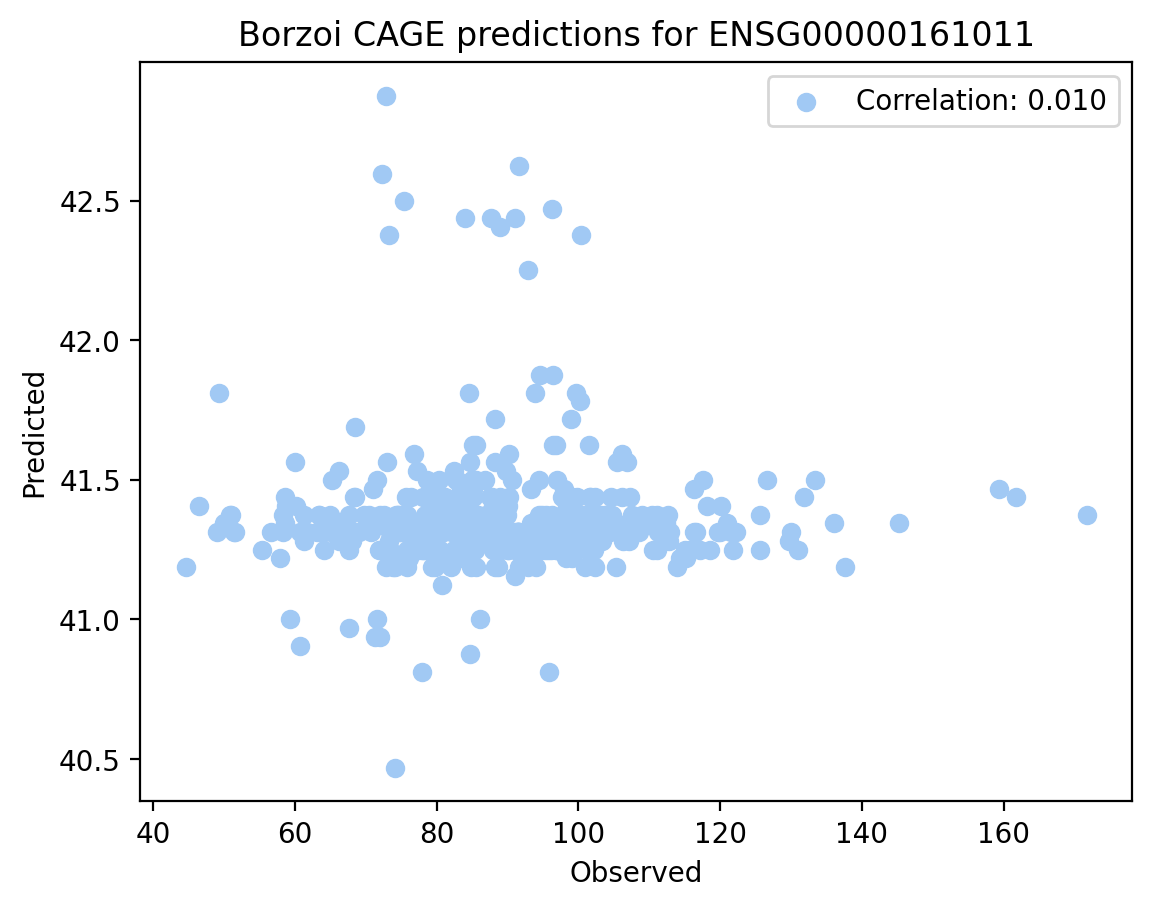

In [40]:
colors = sns.color_palette("pastel")
corr, pval = stats.pearsonr(gex_df['Observed'], gex_df['Predicted'])
plt.scatter(gex_df['Observed'], gex_df['Predicted'], marker='o', color=colors[0], label=f"Correlation: {corr:.3f}")

# Add labels and title
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Borzoi CAGE predictions for ENSG00000161011")

# Show the plot
plt.legend()
plt.show()

## Plotting CAGE tracks along Personalized Genome

There are two CAGE:B lymphoblastoid cell line tracks, for positive and negative strands. I am trying to understand the difference between them.

In [25]:
import kipoiseq
from kipoiseq import Interval
def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

In [21]:
import random
samples = random.sample(individuals, 2)

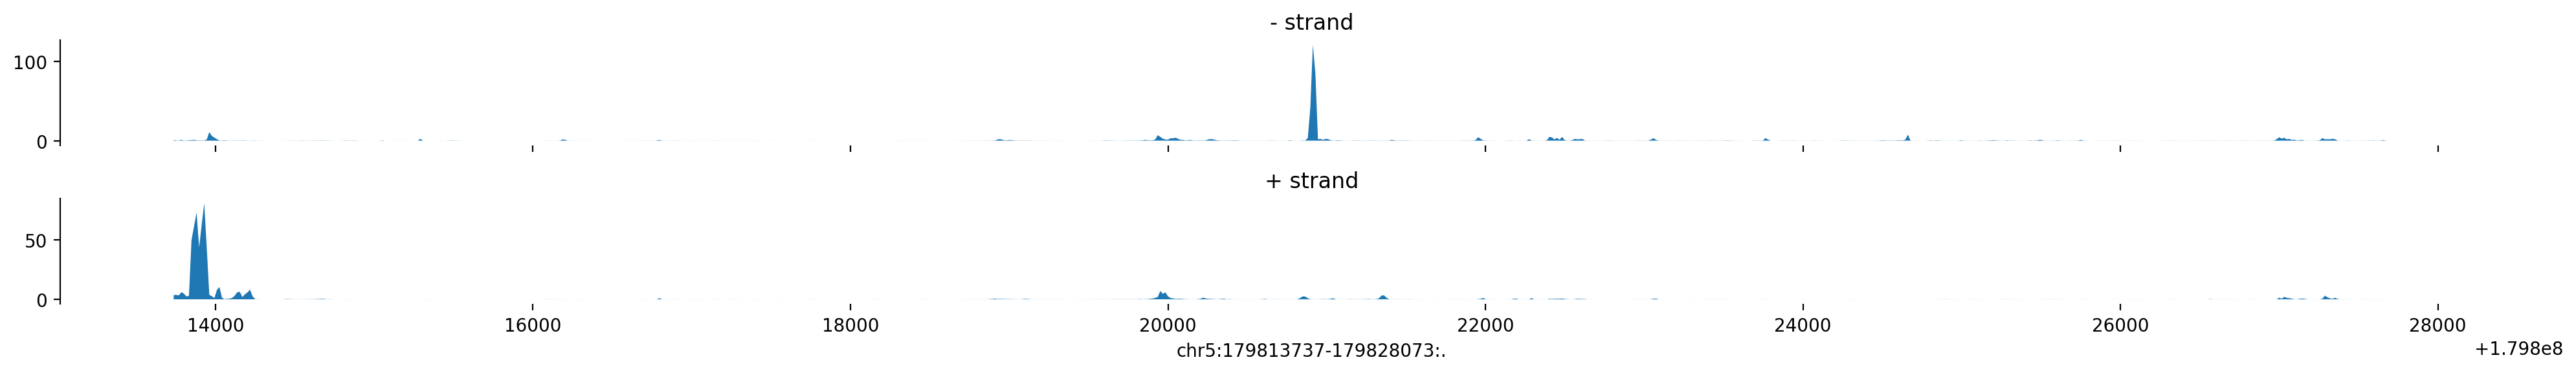

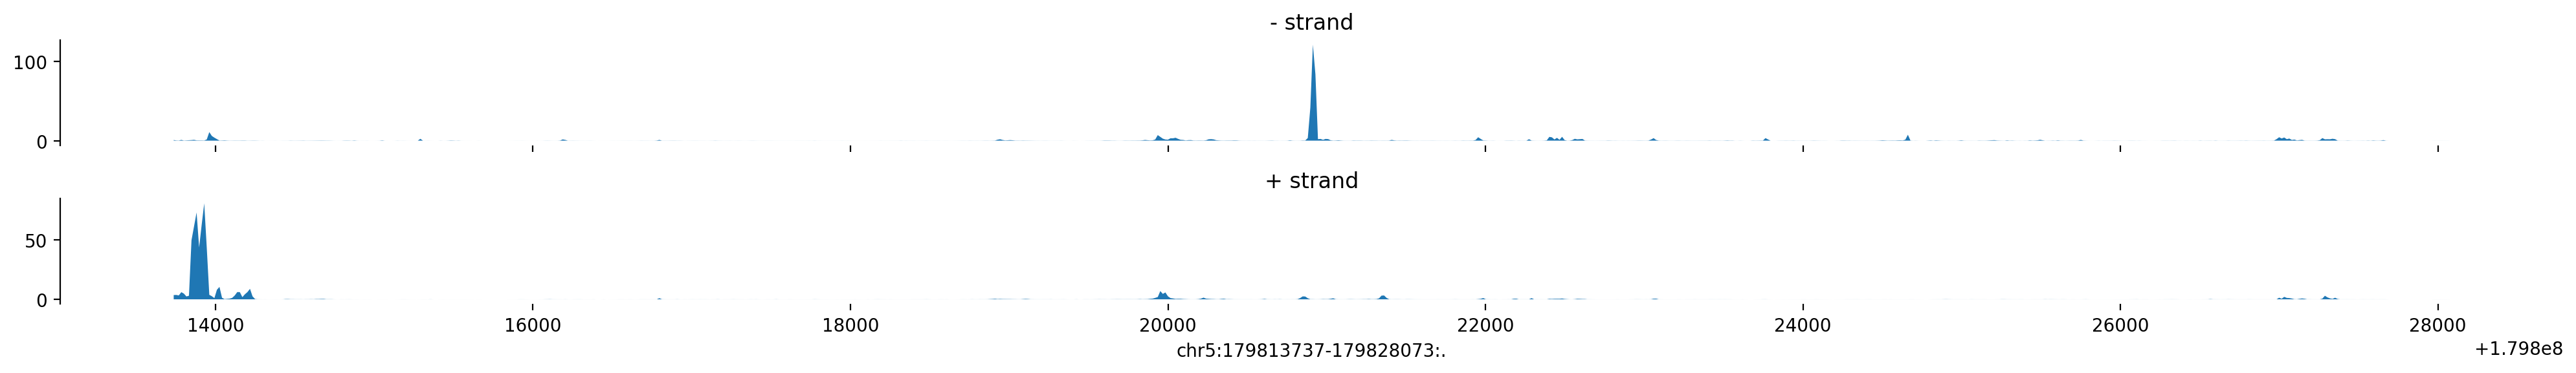

In [32]:
for sample in samples:
    predictions_file = os.path.join(predictions_dir, sample, f'chr{chr}_{interval_start}_{interval_end}_predictions.h5')
    with h5py.File(predictions_file, "r") as hf:
        haplo1 = np.squeeze(hf['haplotype1'][:], axis=0)
        haplo2 = np.squeeze(hf['haplotype2'][:], axis=0)
        predictions = (haplo1 + haplo2) / 2
        tss_interval = kipoiseq.Interval(f'chr{chr}', tss, tss).resize(448*32)
        tracks = {'- strand': predictions[tss_bin-448:tss_bin+448, 870],
                  '+ strand': predictions[tss_bin-448:tss_bin+448, 871]}
        plot_tracks(tracks, tss_interval)

Those predictions were made by subtracting for 0-based indexing of the fasta file. The original results would have given:

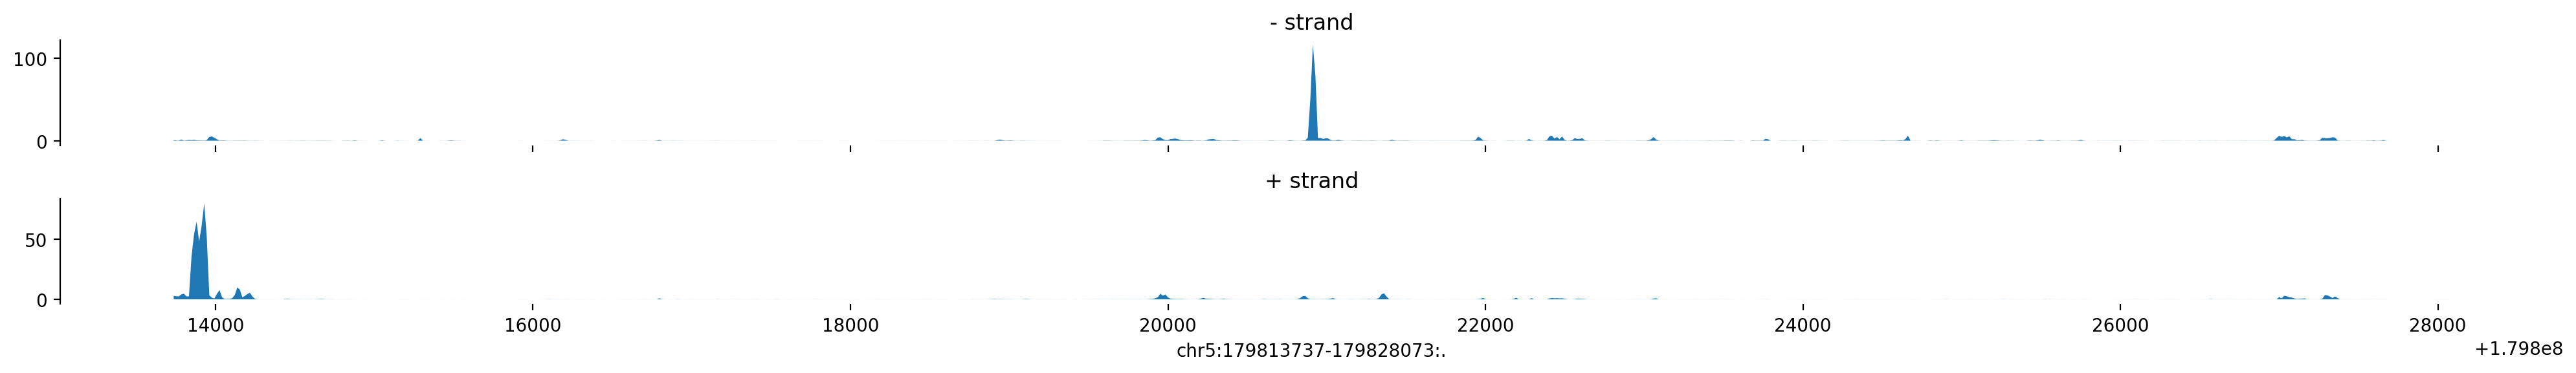

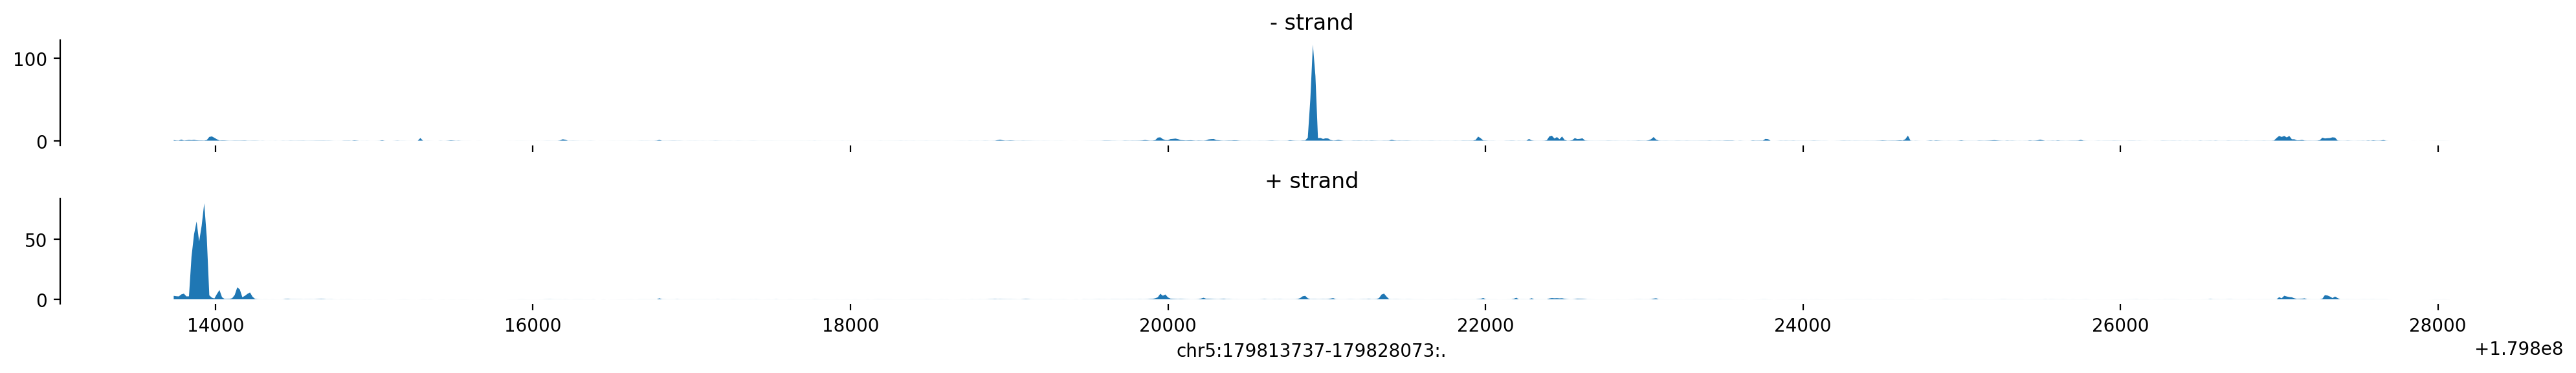

In [37]:
old_predictions_dir="/grand/TFXcan/imlab/users/sabrina/borzoi-personalized-test"
for sample in samples:
    predictions_file = os.path.join(old_predictions_dir, sample, f'chr{chr}_{start}_{end}_predictions.h5')
    with h5py.File(predictions_file, "r") as hf:
        haplo1 = np.mean(hf['haplotype1'][:],axis=0)
        haplo2 = np.mean(hf['haplotype2'][:],axis=0)
        predictions = (haplo1 + haplo2) / 2
        tss_interval = kipoiseq.Interval(f'chr{chr}', tss, tss).resize(448*32)
        tracks = {'- strand': predictions[tss_bin-448:tss_bin+448, 870],
                  '+ strand': predictions[tss_bin-448:tss_bin+448, 871]}
        plot_tracks(tracks, tss_interval)



## Plotting CAGE:LCL+ Predicted vs Observed Expression

In [39]:
stranded_CAGE_predictions = []
for individual in individuals:
    predictions_file = os.path.join(predictions_dir, individual, f'chr{chr}_{interval_start}_{interval_end}_predictions.h5')
    with h5py.File(predictions_file, "r") as hf:
        haplo1 = hf['haplotype1'][:]
        haplo2 = hf['haplotype2'][:]
        CAGE_1 = np.mean(haplo1[:, tss_bin-1:tss_bin+2, 870])
        CAGE_2 = np.mean(haplo2[:, tss_bin-1:tss_bin+2, 870])
        stranded_CAGE_predictions.append((CAGE_1 + CAGE_2) / 2)

In [40]:
gex_df = pd.DataFrame({'Predicted': stranded_CAGE_predictions, 'Observed': observed}, index = individuals)

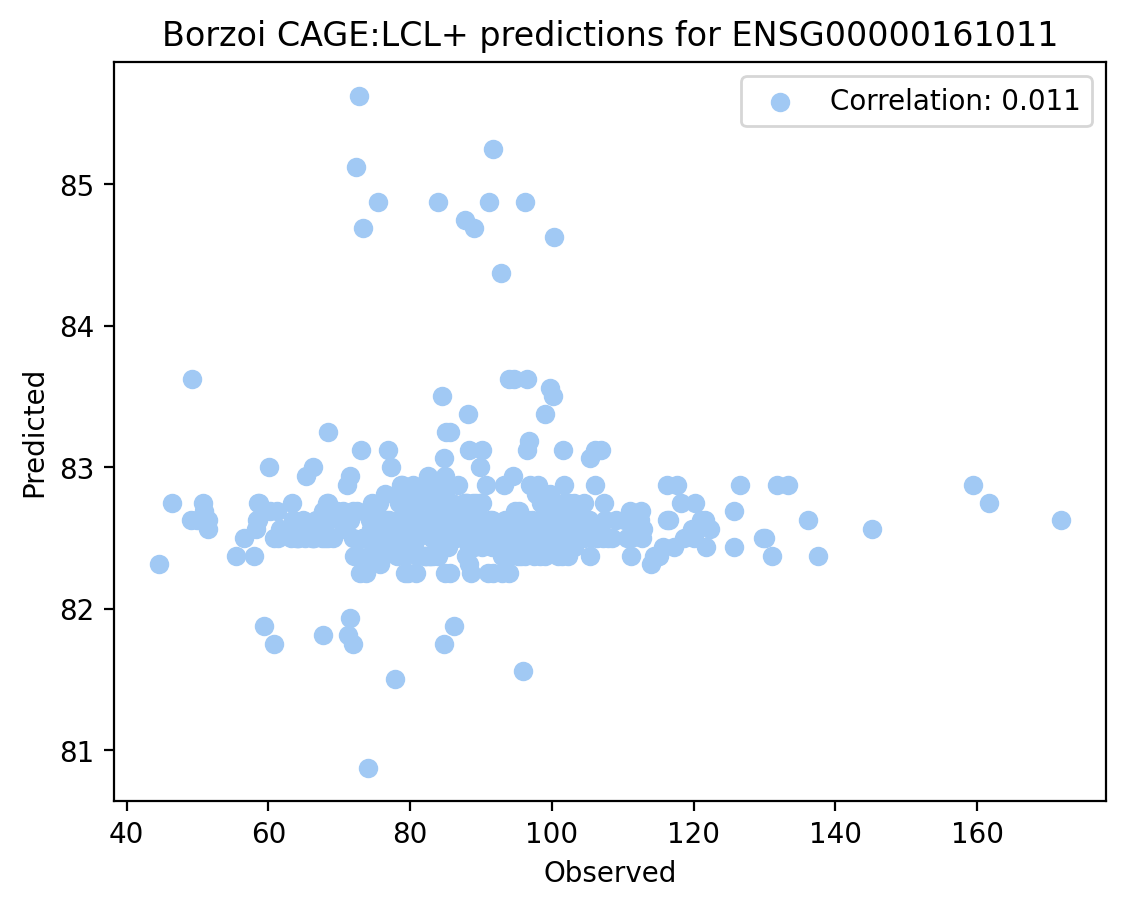

In [41]:
colors = sns.color_palette("pastel")
corr, pval = stats.pearsonr(gex_df['Observed'], gex_df['Predicted'])
plt.scatter(gex_df['Observed'], gex_df['Predicted'], marker='o', color=colors[0], label=f"Correlation: {corr:.3f}")

# Add labels and title
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Borzoi CAGE:LCL+ predictions for ENSG00000161011")

# Show the plot
plt.legend()
plt.show()

In [53]:
old_stranded_CAGE_predictions = []
for individual in individuals:
    predictions_file = os.path.join(old_predictions_dir, sample, f'chr{chr}_{start}_{end}_predictions.h5')
    with h5py.File(predictions_file, "r") as hf:
        haplo1 = np.mean(hf['haplotype1'][:, tss_bin-1:tss_bin+2, 870])
        haplo2 = np.mean(hf['haplotype2'][:, tss_bin-1:tss_bin+2, 870])
        old_stranded_CAGE_predictions.append((haplo1 + haplo2) / 2)

In [54]:
gex_df = pd.DataFrame({'Predicted': old_stranded_CAGE_predictions, 'Observed': observed}, index = individuals)

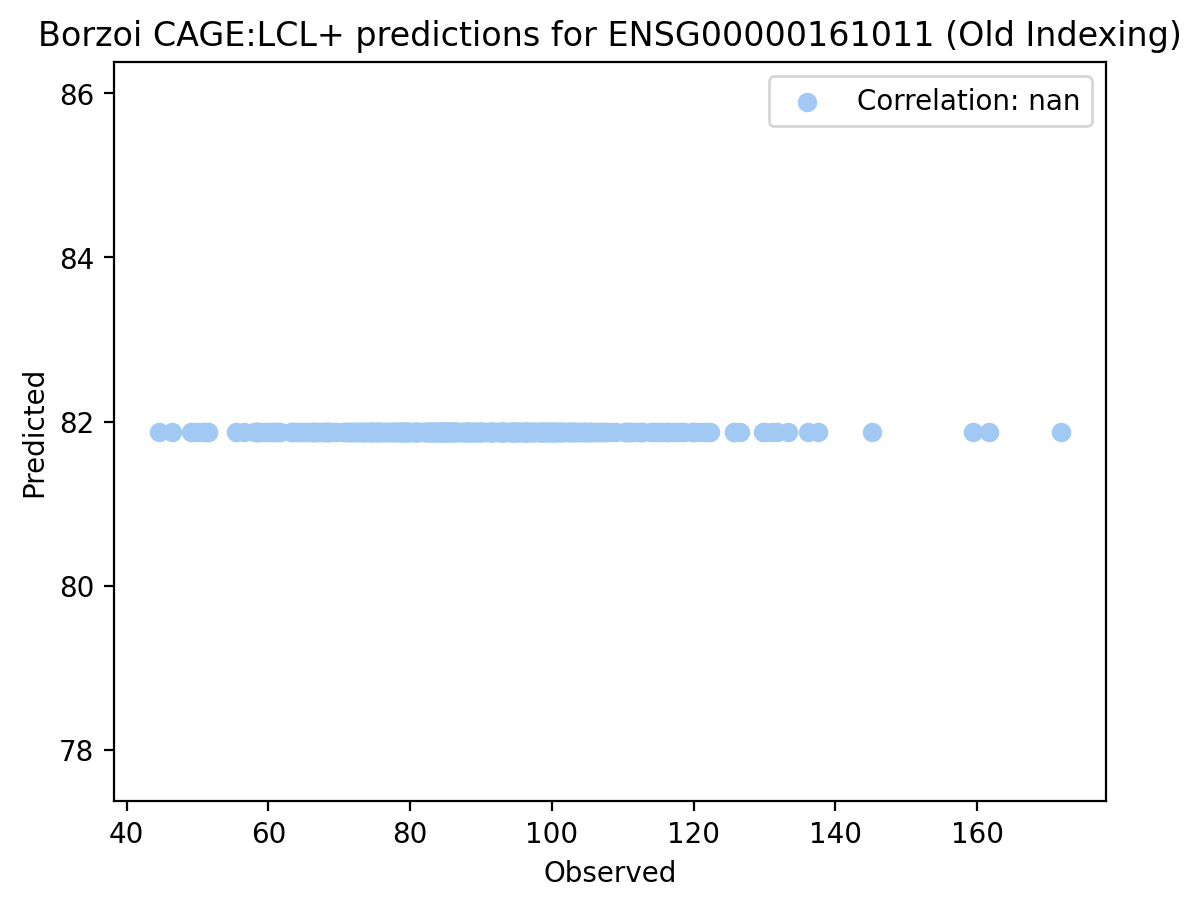

In [55]:
colors = sns.color_palette("pastel")
corr, pval = stats.pearsonr(gex_df['Observed'], gex_df['Predicted'])
plt.scatter(gex_df['Observed'], gex_df['Predicted'], marker='o', color=colors[0], label=f"Correlation: {corr:.3f}")

# Add labels and title
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Borzoi CAGE:LCL+ predictions for ENSG00000161011 (Old Indexing)")

# Show the plot
plt.legend()
plt.show()